In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from items import *


def read_file(file, convert_items=True):
    result = pd.read_parquet(file, engine="pyarrow")
    if convert_items:
        for i in range(0, 36):
            result["kit_" + str(i)] = result["kit_" + str(i)].apply(ItemStack.of)
            result["sorted_" + str(i)] = result["sorted_" + str(i)].apply(ItemStack.of)
    return result

In [7]:
# Split dataset into folders for players with at least 10, 50, or 100 kit preferences saved

def split_datasets(create_folders=False):
    result = []

    if create_folders:
        os.mkdir("kit_data/min_10/")
        os.mkdir("kit_data/min_50/")
        os.mkdir("kit_data/min_100/")

    for user in os.listdir("kit_data/all"):
        df = read_file("kit_data/all/" + user, convert_items=False)
        result.append(df.shape[0])
        if not create_folders:
            continue
        if df.shape[0] >= 10:
            shutil.copy("kit_data/all/" + user, "kit_data/min_10/" + user)

        if df.shape[0] >= 50:
            shutil.copy("kit_data/all/" + user, "kit_data/min_50/" + user)

        if df.shape[0] >= 100:
            shutil.copy("kit_data/all/" + user, "kit_data/min_100/" + user)
    return result

player_sizes = split_datasets()

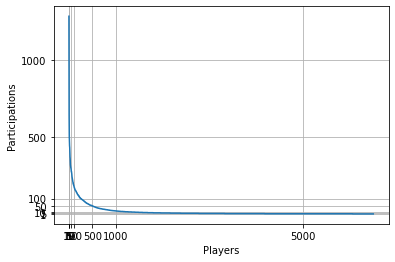

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.axes import Axes

def plot_player_sizes(val):
    plt.plot(sorted(val, reverse=True))
    plt.xlabel("Players")
    plt.ylabel("Matches")
    ax: Axes = plt.gca()
    ax.loglog()
    ax.set_xticks([1, 5, 10, 50, 100, 500, 1000, 5000])
    ax.set_yticks([1, 5, 10, 50, 100, 500, 1000])

    ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(mticker.ScalarFormatter())

    ax.grid(True, which='major')

    return plt

plot_player_sizes(player_sizes).show()

In [4]:
# Count-up all separate kits in the dataset

import threading
from concurrent.futures import ThreadPoolExecutor
from collections import Counter

def count_kits():
    lock = threading.Lock()
    result = Counter()

    def handle_player(file):
        df = read_file(file, convert_items=False)
        start = df.columns.get_loc("kit_0")
        end = df.columns.get_loc("kit_35")
        for _idx, _row in df.iterrows():
            inv = Inventory(sorted(filter(None, _row[start:end].apply(Categories.ofSerialized).unique())))
            lock.acquire()
            result[inv] += 1
            lock.release()

    files = os.listdir("kit_data/min_10")
    with ThreadPoolExecutor(max_workers=32) as executor:
        lock = threading.Lock()
        for player_file in files:
            executor.submit(handle_player, "kit_data/min_10/" + player_file)
    return result

serialized_kits = count_kits()

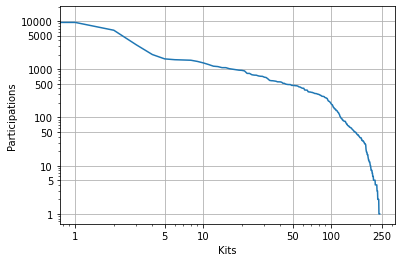

In [13]:
def plot_kit_sizes(val):
    plt.plot(sorted(val, reverse=True))
    plt.xlabel("Kit types")
    plt.ylabel("Matches")

    ax: Axes = plt.gca()
    ax.loglog()
    ax.set_xticks([1, 5, 10, 50, 100, 250])
    ax.set_yticks([1, 5, 10, 50, 100, 500, 1000, 5000, 10000])

    ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(mticker.ScalarFormatter())

    ax.grid(True, which='major')

    return plt

plot_kit_sizes(serialized_kits.values()).show()

In [25]:
def print_kit_counter(kit_counter):
    for kit, count in sorted(kit_counter.items(), key=lambda kv: kv[1], reverse=False):
        print(str(count) + "\t" + str(kit))

trimmed_kits = Counter({ k: v for k, v in serialized_kits.items() if v >= 10})

print_kit_counter(trimmed_kits)

10	[Item.TNT,Item.STICK]
10	[Item.WOOD,Tool.SPADE,Tool.PICKAXE,Tool.AXE,Weapon.BOW,Item.ARROW,Weapon.SWORD,Item.GOLDEN_APPLE,Bucket.BUCKET]
11	[Item.LEAVES,Tool.PICKAXE,Weapon.BOW,Item.ARROW,Weapon.SWORD,Item.GOLDEN_APPLE,Tool.SHEARS]
12	[Weapon.SWORD,Item.POTION]
12	[Item.GRAVEL,Item.SMOOTH_BRICK,Item.STAINED_CLAY,Tool.SPADE,Tool.PICKAXE,Tool.AXE,Weapon.SWORD,Bucket.BUCKET]
12	[Item.WOOD,Item.STAINED_GLASS,Tool.SPADE,Tool.PICKAXE,Tool.AXE,Weapon.BOW,Item.ARROW,Weapon.SWORD,Item.GOLDEN_APPLE,Bucket.BUCKET]
13	[Tool.AXE,Weapon.BOW,Item.ARROW,Weapon.SWORD,Item.POTION]
13	[Item.WOOD,Item.TNT,Item.LEVER,Item.STONE_PLATE,Item.STONE_BUTTON,Item.FENCE,Item.TRAP_DOOR,Item.FENCE_GATE,Item.WOOD_STEP,Item.STAINED_CLAY,Tool.PICKAXE,Tool.AXE,Weapon.BOW,Item.ARROW,Weapon.SWORD,Bucket.BUCKET,Item.REDSTONE,Item.DIODE,Tool.SHEARS]
14	[Item.WOOL,Item.LADDER,Item.STAINED_GLASS,Weapon.BOW,Item.ARROW,Item.GOLDEN_APPLE,Tool.SHEARS,Item.COOKED_BEEF]
15	[Item.WOOD,Item.TNT,Tool.PICKAXE,Item.FLINT_AND_STEEL,We